# Helmholtz equation on Stanford bunny geometry - 1 (Exponential true solution)

In [4]:
import sys
sys.path.append('../../../')
sys.path.append('../../../src')
from swimpde import Domain
from swimpde import BasicAnsatz
from swimpde import HelmholtzSolver
import numpy as np
from sklearn.metrics import mean_squared_error
import csv
import pylab as p
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import numpy as np
import time
import alphashape
import matplotlib.pyplot as plt
cmap =cm.jet


### Load and process data

Number of collocation points:  6000 Number of boundary points (training):  888
Number of test points (uncluding boundary) :  8370


C:\Users\chinm\AppData\Local\Temp\ipykernel_21108\375698084.py:74: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


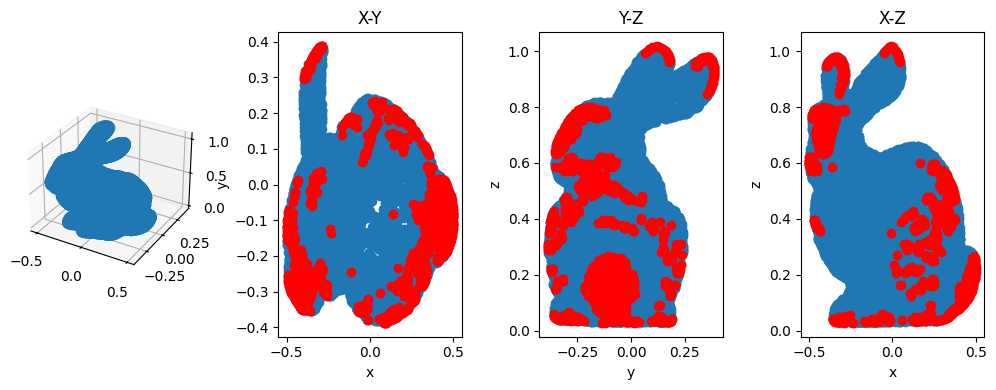

In [5]:
# Create sample points on a sphere using Fibbonacci lattice rule
file = open('../../../data/bunny_vertices.csv')
csvreader = csv.reader(file)
data_points = []
for row in csvreader:
    data_points.append(row)
file.close()
data_points = np.array(data_points)
data_points = np.array(data_points ,dtype=float)

# Create alpha shape
alpha = 1e-4

alpha_shape = alphashape.alphashape(data_points, alpha)

# Extract the vertices of the alpha shape
vertices = np.array(alpha_shape.vertices)

# Find the indices of the data points that are vertices of the alpha shape
indices = []
for vertex in vertices:
    index = np.where((data_points == vertex).all(axis=1))[0][0]
    indices.append(index)

boundary_data = data_points[indices]

# Keep npn-boundary data
indices_to_keep = sorted(set(range(len(data_points))) - set(indices))
interior_data = data_points[indices_to_keep]

boundary_train, boundary_test = train_test_split(boundary_data, test_size=0.1, random_state=42)
# Train test split
n_train = 6000 #8171
n_total = np.shape(interior_data)[0]
n_test =  n_total - n_train

X_train, X_test = train_test_split(interior_data, test_size=n_test/(n_train + n_test), random_state=42)
X_test = np.vstack((X_test, boundary_test))
print("Number of collocation points: ", n_train, "Number of boundary points (training): ",  np.shape(boundary_train)[0])
print("Number of test points (uncluding boundary) : ", np.shape(X_test)[0])

# Set domain 
interior_points = X_train
boundary_points = boundary_train
domain = Domain(
    interior_points=interior_points,
    boundary_points=boundary_points,
)

fig=p.figure(figsize=(10, 4), constrained_layout="True")
fig.add_subplot(141, projection='3d').scatter(data_points[:, 0], data_points[:, 1], data_points[:, 2]) #ax1.set_xlabel("x")

ax1 = fig.add_subplot(142)
ax1.scatter(X_train[:, 0], X_train[:, 1]) 
ax1.scatter(boundary_data[:, 0], boundary_data[:, 1], color='red') 
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title('X-Y')

ax2 = fig.add_subplot(143)
ax2.scatter(X_train[:, 1], X_train[:, 2])
ax2.scatter(boundary_data[:, 1], boundary_data[:, 2], color='red') 
ax2.set_xlabel("y")
ax2.set_ylabel("z")
ax2.set_title('Y-Z')

ax3 =fig.add_subplot(144)#
ax3.scatter(X_train[:, 0], X_train[:, 2])
ax3.scatter(boundary_data[:, 0], boundary_data[:, 2], color='red') 
ax3.set_xlabel("x")
ax3.set_ylabel("z")
ax3.set_title('X-Z')
fig.tight_layout()


### Problem setup and SWIM and ELM models

In [6]:
# This is mentioned just to pass it as an argument!
boundary_condition = "zero dirichlet" #"periodic strict" #strict

# forcing
def forcing(v):
    return 2. * np.exp(v[:, 0] + v[:, 1] + v[:, 2])

# Analytical solution
def analytical_sol(v):
    return np.exp((v[:, 0] + v[:, 1] + v[:, 2]))

# True solution
Y_train = analytical_sol(X_train)
Y_test = analytical_sol(X_test)

# Store errors and time required for each seed
seeds = [1, 2, 3]
rel_err_swim = np.ones((len(seeds), ))
time_swim = np.ones((len(seeds), ))
rmse_swim = np.ones((len(seeds), ))
rel_err_elm = np.ones((len(seeds), ))
time_elm = np.ones((len(seeds), ))
rmse_elm = np.ones((len(seeds), ))

j = 0
for seed in seeds:
    ansatz_elm = BasicAnsatz(
        activation='tanh',
        n_neurons=3000,
        random_state=seed,
        regularization_scale=1e-12,
        parameter_sampler="random"
    )
    ansatz_swim = BasicAnsatz(
        activation='tanh',
        n_neurons=3000,
        random_state=seed,
        regularization_scale=1e-12
    )
    helmholtz_solver_elm = HelmholtzSolver(
                        domain=domain, 
                        ansatz=ansatz_elm,
                        forcing=forcing,
                        regularization_scale=1e-12
    )
    helmholtz_solver_swim = HelmholtzSolver(
        domain=domain, 
        ansatz=ansatz_swim,
        forcing=forcing,
        regularization_scale=1e-12
    )
    t_elm_start = time.time()
    helmholtz_solver_elm.fit(num_svd=1200);
    t_elm_stop = time.time()
    time_elm[j] = t_elm_stop - t_elm_start

    t_swim_start = time.time()
    helmholtz_solver_swim.fit(num_svd=1200);
    t_swim_stop = time.time()
    time_swim[j] = t_swim_stop - t_swim_start

    # Evaluate for SWIM and ELM
    sol_test_elm  =  helmholtz_solver_elm.evaluate(X_test)
    sol_test_swim =  helmholtz_solver_swim.evaluate(X_test)

    # Evaluate metrics
    mse_elm = mean_squared_error(sol_test_elm, Y_test)  # mean squared error
    rmse_elm[j] = np.sqrt(mse_elm)  # Root Mean Squared Error
    mse_swim = mean_squared_error(sol_test_swim, Y_test)  # mean squared error
    rmse_swim[j] = np.sqrt(mse_swim)  # Root Mean Squared Error
                    
    rel_err_elm[j] = np.linalg.norm(sol_test_elm - Y_test, 2)/np.linalg.norm(Y_test, 2)
    rel_err_swim[j] = np.linalg.norm(sol_test_swim - Y_test, 2)/np.linalg.norm(Y_test, 2)
    print('Relative L2 test error ELM: %e' % (rel_err_elm[j]))
    print('Relative L2 test error SWIM: %e' % (rel_err_swim[j]))
    j = j + 1


# RMSE and relative l-2 errors (mean and std) and time measurements
print('time_swim = ', np.mean(time_swim), 'time_elm = ', np.mean(time_elm))
print('rmse elm = ', np.mean(rmse_elm), '+-', np.std(rmse_elm))
print('rmse swim = ', np.mean(rmse_swim), '+-', np.std(rmse_swim))
print('rel error elm = ', np.mean(rel_err_elm), '+-', np.std(rel_err_elm))
print('rel error swim = ', np.mean(rel_err_swim), '+-', np.std(rel_err_swim))


Relative L2 test error ELM: 5.571058e-07
Relative L2 test error SWIM: 1.909372e-04
Relative L2 test error ELM: 1.083833e-06
Relative L2 test error SWIM: 1.958418e-04
Relative L2 test error ELM: 4.310144e-07
Relative L2 test error SWIM: 3.981213e-04
time_swim =  55.63307229677836 time_elm =  56.81566985448202
rmse elm =  1.0550151380735436e-06 +- 4.319147429310878e-07
rmse swim =  0.0003996623169101629 +- 0.00014745937642879667
rel error elm =  6.90651153637744e-07 +- 2.8274704761412747e-07
rel error swim =  0.00026163344039173035 +- 9.653225320654256e-05


### Plot test errors on the Stanford bunny

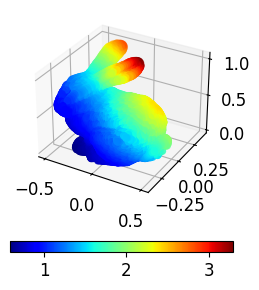

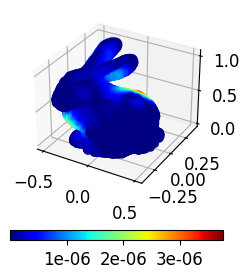

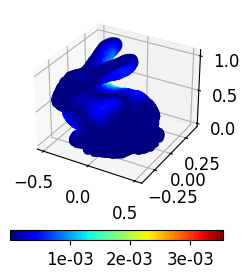

In [7]:
# Absolute errors to be used in plots
abs_err_elm = abs(sol_test_elm-Y_test)
abs_err_swim = abs(sol_test_swim-Y_test)


# Plot of ground truth
fontsize = 12
fig = p.figure(figsize=(4, 3))
ax= fig.add_subplot(projection='3d')
true_plot = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=Y_test, 
                          marker='o', cmap=cmap)# vmin=datamin, vmax=datamax,
plt.tick_params(axis='both', labelsize=fontsize)
cb = fig.colorbar(true_plot, ax=ax, location='bottom',fraction=0.046)
cb.ax.tick_params(labelsize=fontsize)
fig.tight_layout()
plt.savefig('cg1_true_sol_abs.pdf', bbox_inches="tight")

# Plot of relative error
fig = p.figure(figsize=(4, 3))
ax =fig.add_subplot(projection='3d')#
rel_err_plot = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=abs_err_elm, 
                          marker='o', cmap=cmap)
cb = fig.colorbar(rel_err_plot , ax=ax , location='bottom',fraction=0.046, format='%.0e')
cb.ax.tick_params(labelsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.savefig('cg1_abs_err_elm_.pdf', bbox_inches="tight")


# Plot of relative error
fig = p.figure(figsize=(4, 3))
ax =fig.add_subplot(projection='3d')#
rel_err_plot = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=abs(abs_err_swim), 
                          marker='o', cmap=cmap) 
cb = fig.colorbar(rel_err_plot , ax=ax , location='bottom',fraction=0.046, format='%.0e')
cb.ax.tick_params(labelsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.savefig('cg1_abs_err_swim.pdf', bbox_inches="tight")

